In [16]:
import cv2
import torch
import numpy as np
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import zipfile

In [17]:
with zipfile.ZipFile('/content/MNIST_ORG.zip', 'r') as zip_ref:
    zip_ref.extractall('mnist')

In [18]:
import idx2numpy

X_train = idx2numpy.convert_from_file('/content/mnist/train-images.idx3-ubyte')
y_train = idx2numpy.convert_from_file('/content/mnist/train-labels.idx1-ubyte')
X_test = idx2numpy.convert_from_file('/content/mnist/t10k-images.idx3-ubyte')
y_test = idx2numpy.convert_from_file('/content/mnist/t10k-labels.idx1-ubyte')

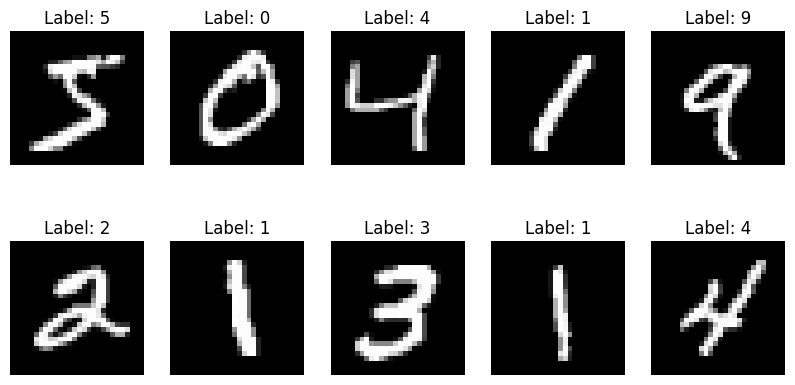

In [19]:
# prompt: Visualize a few samples from the dataset to understand the data distribution.

import matplotlib.pyplot as plt

# Display a few samples
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()


In [20]:
# prompt: save image to png Xtrain[0]

from PIL import Image
# Assuming X_train[0] is a NumPy array representing an image
img = Image.fromarray(X_train[0])
# Save the image as a PNG file
img.save("image.png")


In [21]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert image to a tensor and normalize to [0, 1]
        image = torch.tensor(image, dtype=torch.float).unsqueeze(0) / 255.0
        label = torch.tensor(label, dtype=torch.long)
        return image, label


In [22]:
train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.Inf
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

In [25]:
# Define the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(7 * 7 * 128, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = x.view(-1, 7 * 7 * 128)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1/50, Training Loss: 0.1509, Validation Loss: 0.0455, Training Accuracy: 0.9522, Validation Accuracy: 0.9855
Epoch 2/50, Training Loss: 0.0420, Validation Loss: 0.0378, Training Accuracy: 0.9869, Validation Accuracy: 0.9873
Epoch 3/50, Training Loss: 0.0289, Validation Loss: 0.0322, Training Accuracy: 0.9906, Validation Accuracy: 0.9898
Epoch 4/50, Training Loss: 0.0228, Validation Loss: 0.0238, Training Accuracy: 0.9927, Validation Accuracy: 0.9923
Epoch 5/50, Training Loss: 0.0173, Validation Loss: 0.0265, Training Accuracy: 0.9946, Validation Accuracy: 0.9922
Epoch 6/50, Training Loss: 0.0131, Validation Loss: 0.0280, Training Accuracy: 0.9953, Validation Accuracy: 0.9919
Epoch 7/50, Training Loss: 0.0122, Validation Loss: 0.0313, Training Accuracy: 0.9960, Validation Accuracy: 0.9918
Epoch 8/50, Training Loss: 0.0098, Validation Loss: 0.0327, Training Accuracy: 0.9970, Validation Accuracy: 0.9925
Epoch 9/50, Training Loss: 0.0078, Validation Loss: 0.0297, Training Accuracy: 0

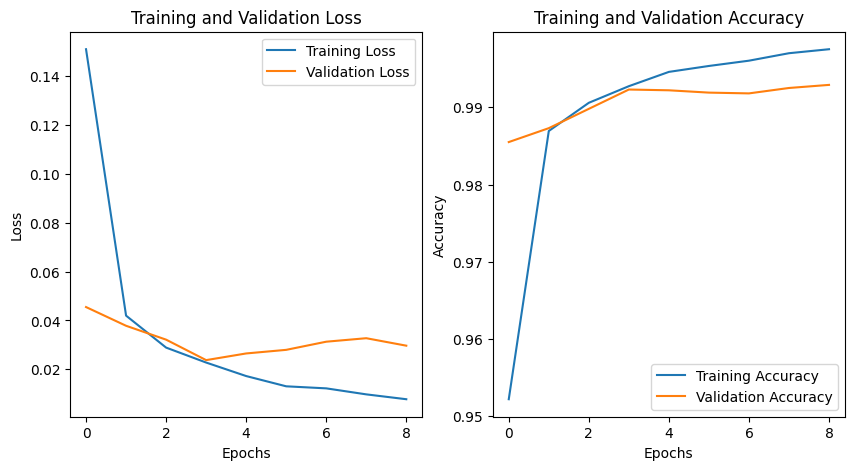

In [27]:
import matplotlib.pyplot as plt

# Initialize the early stopping object
early_stopping = EarlyStopping(patience=5, verbose=True)

# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Function to calculate accuracy
def calculate_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    return correct / len(target)

# Training loop with early stopping
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data and target to GPU
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        correct_train += calculate_accuracy(output, target) * data.size(0)
        total_train += data.size(0)
    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)  # Store train loss
    train_accuracies.append(train_accuracy)  # Store train accuracy

    # Validation step
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)  # Move data and target to GPU
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

            correct_val += calculate_accuracy(output, target) * data.size(0)
            total_val += data.size(0)
    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)  # Store validation loss
    val_accuracies.append(val_accuracy)  # Store validation accuracy

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
          f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Check early stopping condition
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Save the model
torch.save(model.state_dict(), 'simple_cnn.pth')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Save the plot as a PNG file
plt.savefig('training_validation_loss_accuracy.png')
plt.show()


In [40]:
loaded_model = SimpleCNN().to(device)
loaded_model.load_state_dict(torch.load('simple_cnn.pth', map_location=device))

<All keys matched successfully>

In [41]:
from PIL import Image
import torchvision.transforms as transforms

# Load the image
image_path = 'image.png'  # Replace with your image path
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST dataset
])
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU

# Make a prediction
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    _, predicted = torch.max(output.data, 1)
    print(f'Predicted digit: {predicted.item()}')

Predicted digit: 5


In [42]:
# prompt: Report key metrics including accuracy, precision, recall, and F1-score on validation dataset

from sklearn.metrics import classification_report

# Get predictions for the validation set
y_true = []
y_pred = []
loaded_model.eval()
with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = loaded_model(data)
        _, predicted = torch.max(output.data, 1)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate and print the classification report
report = classification_report(y_true, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



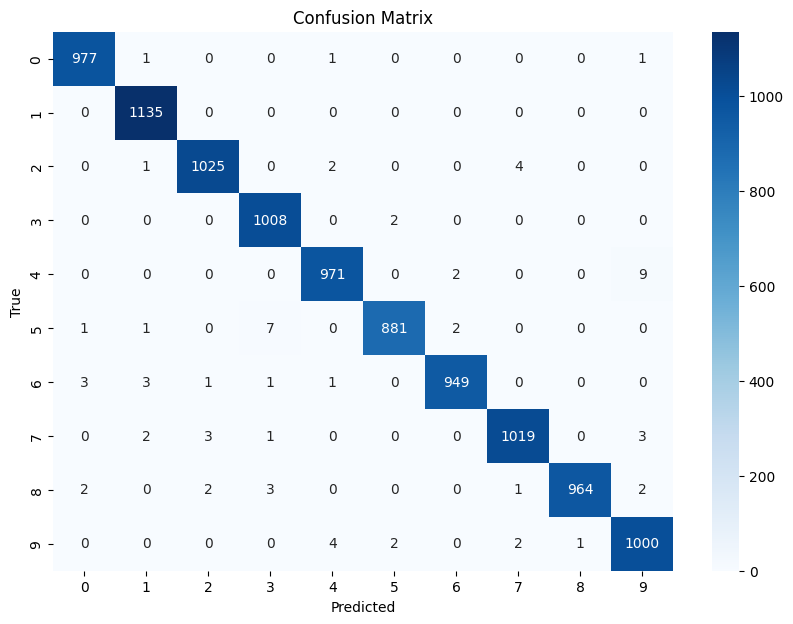

In [43]:
# prompt: Generate and analyze the confusion matrix.

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
